#프로젝트: 한국어 데이터로 챗봇 만들기

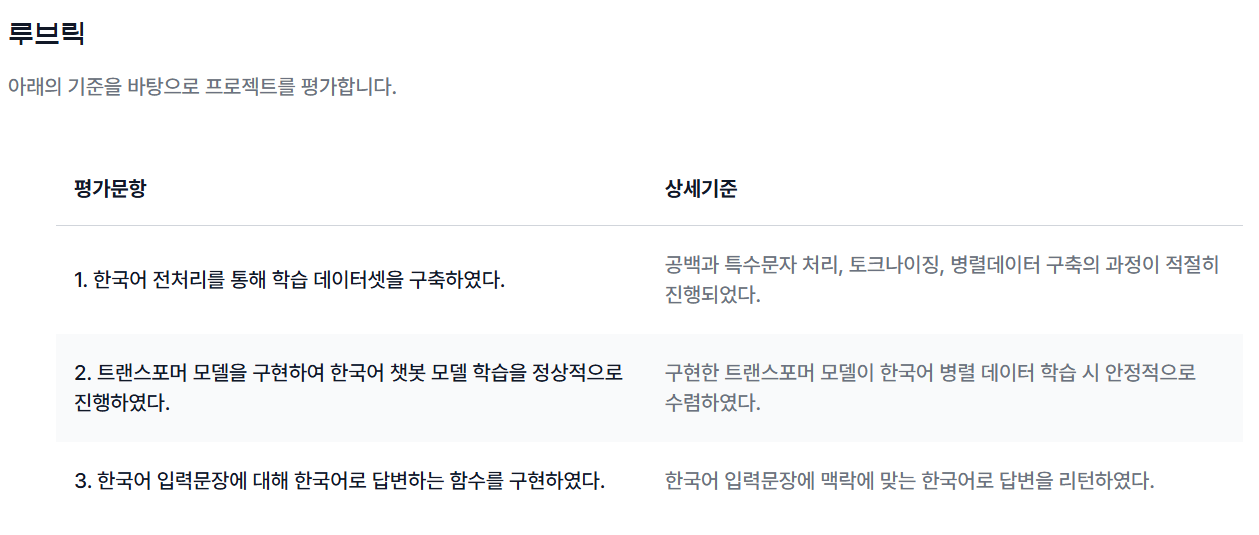

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Step 1. 데이터 수집하기

In [ ]:
import os
import pandas as pd

# 폴더 만들기
data_dir = '/content/aiffel/transformer_chatbot/data'
os.makedirs(data_dir, exist_ok=True)

# GitHub에서 직접 읽고 저장
url = 'https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv'
save_path = os.path.join(data_dir, 'ChatbotData.csv')

df = pd.read_csv(url)
df.to_csv(save_path, index=False)

print(f"데이터 저장 완료: {save_path}")


데이터 저장 완료: /content/aiffel/transformer_chatbot/data/ChatbotData.csv


In [ ]:
# 저장된 경로에서 다시 불러오기
df_check = pd.read_csv(save_path)
df_check.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


###Step 2. 데이터 전처리하기
---
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [ ]:
# 전처리 함수: 간단한 특수문자 제거 + 공백 정리 (숫자 유지)
def preprocess_sentence(sentence):
    sentence = str(sentence).strip().lower()  # 소문자화 + 양쪽 공백 제거

    # 구두점(punctuation) 주변에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 여러 공백은 하나로
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 한글, 영어, 숫자, 주요 구두점만 남기고 나머지 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence)

    sentence = sentence.strip()
    return sentence

In [ ]:
# 질문과 대답 각각 전처리 적용
questions = [preprocess_sentence(q) for q in df['Q']]
answers = [preprocess_sentence(a) for a in df['A']]

# 확인
for i in range(5):
    print(f"Q: {questions[i]}")
    print(f"A: {answers[i]}")
    print()

Q: 12시 땡 !
A: 하루가 또 가네요 .

Q: 1지망 학교 떨어졌어
A: 위로해 드립니다 .

Q: 3박4일 놀러가고 싶다
A: 여행은 언제나 좋죠 .

Q: 3박4일 정도 놀러가고 싶다
A: 여행은 언제나 좋죠 .

Q: ppl 심하네
A: 눈살이 찌푸려지죠 .



###Step 3. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.


In [ ]:
# 모든 문장을 하나로 합쳐 단어장 생성용 코퍼스 만들기
corpus = questions + answers

In [ ]:
# SubwordTextEncoder 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=2**14)

# 시작 토큰과 종료 토큰의 ID
START_TOKEN_ID = tokenizer.vocab_size
END_TOKEN_ID = tokenizer.vocab_size + 1

# 단어장 크기 (추가 토큰 포함)
VOCAB_SIZE = tokenizer.vocab_size + 2

print(f'단어장 크기: {VOCAB_SIZE}')

단어장 크기: 21836


In [ ]:
# 문장을 토큰화하는 함수
def tokenize_and_filter(inputs, outputs, max_length=40):
    tokenized_inputs, tokenized_outputs = [], []

    for (input_sentence, output_sentence) in zip(inputs, outputs):
        # 각 문장을 정수 시퀀스로 변환
        input_sentence_tokens = [START_TOKEN_ID] + tokenizer.encode(input_sentence) + [END_TOKEN_ID]
        output_sentence_tokens = [START_TOKEN_ID] + tokenizer.encode(output_sentence) + [END_TOKEN_ID]

        # 최대 길이 체크
        if len(input_sentence_tokens) <= max_length and len(output_sentence_tokens) <= max_length:
            tokenized_inputs.append(input_sentence_tokens)
            tokenized_outputs.append(output_sentence_tokens)

    # 패딩 추가
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_length, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=max_length, padding='post')

    return tokenized_inputs, tokenized_outputs

In [ ]:
# 토큰화 및 필터링 적용
MAX_LENGTH = 40
questions_tokens, answers_tokens = tokenize_and_filter(questions, answers, MAX_LENGTH)

print(f'질문 토큰화 결과 크기: {len(questions_tokens)}')
print(f'대답 토큰화 결과 크기: {len(answers_tokens)}')

질문 토큰화 결과 크기: 11823
대답 토큰화 결과 크기: 11823


In [ ]:
# 데이터셋 생성
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더 입력과 타겟 구분 (교사 강요를 위한 준비)
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_tokens,
        'dec_inputs': answers_tokens[:, :-1]  # 마지막 토큰 제외
    },
    {
        'outputs': answers_tokens[:, 1:]  # 첫 번째 토큰 제외
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print(f'데이터셋: {dataset}')

데이터셋: <_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


###Step 4. 모델 구성하기
---
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

1. 포지셔널 인코딩

In [ ]:
# 위치 인코딩
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # sin 함수는 짝수 인덱스에 적용
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # cos 함수는 홀수 인덱스에 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

2. 스케일드 닷 프로덕트 어텐션

In [ ]:
# 어텐션 마스킹 함수
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [ ]:
# 스케일드 닷 프로덕트 어텐션
def scaled_dot_product_attention(q, k, v, mask):
    # Q와 K의 곱셈 연산
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스킹 적용
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # 소프트맥스로 어텐션 가중치 계산
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # 가중치와 V 곱하기
    output = tf.matmul(attention_weights, v)

    return output, attention_weights

3. 멀티헤드 어텐션

In [ ]:
# 멀티헤드 어텐션 레이어
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # 스케일드 닷 프로덕트 어텐션 적용
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

4. 포인트 와이즈 피드포워드 네트워크

In [ ]:
# 포지션 와이즈 피드 포워드 네트워크
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

5. 인코더 레이어

In [ ]:
# 인코더 레이어
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(v=x, k=x, q=x, mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

6. 디코더 레이어

In [ ]:
# 디코더 레이어
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(v=x, k=x, q=x, mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            v=enc_output, k=enc_output, q=out1, mask=padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

7. 전체 인코더

In [ ]:
# 인코더
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                              self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # 입력을 임베딩
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x=x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, d_model)

8. 전체 디코더

In [ ]:
# 디코더
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x=x,
                enc_output=enc_output,
                training=training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

9. 트랜스포머 전체 모델

In [ ]:
# 패딩 마스크 생성: 입력 시퀀스에서 패딩 토큰(0)에 해당하는 위치를 마스킹
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (배치 크기, 1, 1, 시퀀스 길이)

# 미래 토큰 마스킹 (Look-ahead mask): 디코더가 미래의 토큰을 보지 못하게 막음
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (시퀀스 길이, 시퀀스 길이)

# 전체 마스크 생성 함수: 인코더/디코더 패딩 마스크와 Look-ahead 마스크 결합
def create_masks(inp, tar):
    # 인코더 입력에 대한 패딩 마스크
    enc_padding_mask = create_padding_mask(inp)

    # 디코더 입력에 대한 look-ahead 마스크와 패딩 마스크 결합
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    # 디코더의 인코더 출력에 적용할 패딩 마스크
    dec_padding_mask = create_padding_mask(inp)

    return enc_padding_mask, combined_mask, dec_padding_mask


In [ ]:
# 트랜스포머 모델
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                             target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training=False):
        # Keras 모델은 inputs를 리스트나 딕셔너리로 받음
        inp, tar = inputs['inputs'], inputs['dec_inputs']

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)

        enc_output = self.encoder(
            x=inp,
            training=training,
            mask=enc_padding_mask
        )

        dec_output, attention_weights = self.decoder(
            x=tar,
            enc_output=enc_output,
            training=training,
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )

        final_output = self.final_layer(dec_output)
        return final_output

10. 모델 생성

In [ ]:
# 학습 파라미터 설정
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

# 모델 인스턴스 생성
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    pe_input=MAX_LENGTH,
    pe_target=MAX_LENGTH,
    rate=dropout_rate
)

In [ ]:
# 손실 함수 정의
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(
        real, pred, from_logits=True)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

# 정확도 계산 함수 정의
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), dtype=tf.int32))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

In [ ]:
# 학습률 스케줄러 정의
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # step을 float32로 명시적 변환 추가
        step = tf.cast(step, tf.float32)

        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 학습률 설정 및 옵티마이저 정의
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 체크포인트 설정
checkpoint_path = './checkpoints/transformer'
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
# 학습 함수 정의
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions = transformer(
            {
                'inputs': inp,
                'dec_inputs': tar_inp
            },
            training=True
        )

        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
# tqdm 라이브러리 설치 및 가져오기
!pip install tqdm
from tqdm.notebook import tqdm

# 학습 메트릭 정의
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# 모델 학습
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_state()
    train_accuracy.reset_state()

    print(f"에포크 {epoch + 1}/{EPOCHS} 시작...")

    # tqdm으로 배치 순회를 감싸서 진행 표시줄 표시
    for (batch, (inp, tar)) in tqdm(enumerate(dataset), total=len(dataset)):
        train_step(inp['inputs'], tar['outputs'])

    # 에포크 완료 후 결과 출력
    epoch_time = time.time() - start
    print(f'에포크 {epoch + 1} 완료 - 손실: {train_loss.result():.4f}, 정확도: {train_accuracy.result():.4f}, 시간: {epoch_time:.2f}초')

    # 에포크가 끝날 때마다 체크포인트 저장
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'에포크 {epoch + 1}에 체크포인트 저장: {ckpt_save_path}')

    print("-" * 50)

에포크 1/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 1 완료 - 손실: 9.5044, 정확도: 0.1683, 시간: 56.07초
--------------------------------------------------
에포크 2/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 2 완료 - 손실: 7.8119, 정확도: 0.3888, 시간: 17.51초
--------------------------------------------------
에포크 3/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 3 완료 - 손실: 5.7897, 정확도: 0.4139, 시간: 17.72초
--------------------------------------------------
에포크 4/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 4 완료 - 손실: 4.8932, 정확도: 0.4143, 시간: 17.95초
--------------------------------------------------
에포크 5/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 5 완료 - 손실: 4.5224, 정확도: 0.4252, 시간: 18.24초
에포크 5에 체크포인트 저장: ./checkpoints/transformer/ckpt-1
--------------------------------------------------
에포크 6/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 6 완료 - 손실: 4.2652, 정확도: 0.4419, 시간: 18.36초
--------------------------------------------------
에포크 7/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 7 완료 - 손실: 4.0257, 정확도: 0.4543, 시간: 18.28초
--------------------------------------------------
에포크 8/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 8 완료 - 손실: 3.7783, 정확도: 0.4689, 시간: 18.15초
--------------------------------------------------
에포크 9/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 9 완료 - 손실: 3.4971, 정확도: 0.4905, 시간: 18.17초
--------------------------------------------------
에포크 10/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 10 완료 - 손실: 3.1797, 정확도: 0.5203, 시간: 18.24초
에포크 10에 체크포인트 저장: ./checkpoints/transformer/ckpt-2
--------------------------------------------------
에포크 11/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 11 완료 - 손실: 2.8396, 정확도: 0.5576, 시간: 18.25초
--------------------------------------------------
에포크 12/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 12 완료 - 손실: 2.5075, 정확도: 0.5964, 시간: 18.23초
--------------------------------------------------
에포크 13/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 13 완료 - 손실: 2.1783, 정확도: 0.6379, 시간: 18.22초
--------------------------------------------------
에포크 14/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 14 완료 - 손실: 1.8656, 정확도: 0.6808, 시간: 18.20초
--------------------------------------------------
에포크 15/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 15 완료 - 손실: 1.5678, 정확도: 0.7247, 시간: 18.20초
에포크 15에 체크포인트 저장: ./checkpoints/transformer/ckpt-3
--------------------------------------------------
에포크 16/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 16 완료 - 손실: 1.3199, 정확도: 0.7576, 시간: 18.20초
--------------------------------------------------
에포크 17/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 17 완료 - 손실: 1.0918, 정확도: 0.7890, 시간: 18.21초
--------------------------------------------------
에포크 18/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 18 완료 - 손실: 0.9088, 정확도: 0.8175, 시간: 18.22초
--------------------------------------------------
에포크 19/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 19 완료 - 손실: 0.7701, 정확도: 0.8405, 시간: 18.22초
--------------------------------------------------
에포크 20/20 시작...


  0%|          | 0/185 [00:00<?, ?it/s]

에포크 20 완료 - 손실: 0.6517, 정확도: 0.8595, 시간: 18.23초
에포크 20에 체크포인트 저장: ./checkpoints/transformer/ckpt-4
--------------------------------------------------


In [ ]:
# 체크포인트 복원
ckpt.restore(ckpt_manager.latest_checkpoint)

if ckpt_manager.latest_checkpoint:
    print(f"체크포인트에서 복원됨: {ckpt_manager.latest_checkpoint}")
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
else:
    print("체크포인트가 없습니다. 처음부터 학습을 시작합니다.")
    start_epoch = 0

# 이어서 학습 (start_epoch부터 100까지)
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()

    train_loss.reset_state()
    train_accuracy.reset_state()

    print(f"에포크 {epoch + 1}/{EPOCHS} 시작...")

    for (batch, (inp, tar)) in tqdm(enumerate(dataset), total=len(dataset)):
        train_step(inp['inputs'], tar['outputs'])

    epoch_time = time.time() - start
    print(f'에포크 {epoch + 1} 완료 - 손실: {train_loss.result():.4f}, 정확도: {train_accuracy.result():.4f}, 시간: {epoch_time:.2f}초')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'에포크 {epoch + 1}에 체크포인트 저장: {ckpt_save_path}')

    print("-" * 50)


###Step 5. 모델 평가하기
---
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [ ]:
# 모델 체크포인트 로드 (학습 이후)
# 저장된 체크포인트가 있으면 최신 체크포인트를 복원
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f'최신 체크포인트 복원: {ckpt_manager.latest_checkpoint}')

최신 체크포인트 복원: ./checkpoints/transformer/ckpt-4


In [ ]:
# 응답 생성 함수 정의
def evaluate(sentence):
    # 문장 전처리
    sentence = preprocess_sentence(sentence)

    # 문장 토큰화
    encoder_input = tokenizer.encode(sentence)
    encoder_input = [START_TOKEN_ID] + encoder_input + [END_TOKEN_ID]
    encoder_input = tf.expand_dims(encoder_input, 0)

    # 디코더 입력은 시작 토큰으로 시작
    decoder_input = [START_TOKEN_ID]
    output = tf.expand_dims(decoder_input, 0)

    # 자동 회귀(auto-regressive) 방식으로 출력 생성
    for i in range(MAX_LENGTH):
        predictions = transformer(
            {
                'inputs': encoder_input,
                'dec_inputs': output
            },
            training=False
        )

        # 마지막 토큰의 예측에서 다음 토큰 선택
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)  # int32로 명시적 변환

        # 종료 토큰이 예측되면 반환
        if tf.equal(predicted_id, END_TOKEN_ID):  # tf.equal 사용
            break

        # 예측된 ID를 디코더 입력에 연결
        output = tf.concat([output, predicted_id], axis=-1)

    # 출력 텍스트로 변환
    output_text = tokenizer.decode([i for i in output[0].numpy() if i < tokenizer.vocab_size])

    return output_text

In [ ]:
# 챗봇 응답 함수
def chat_response(sentence):
    result = evaluate(sentence)

    # 특수 토큰 제거 및 정리
    result = result.replace('<start>', '').replace('<end>', '').strip()

    return result

In [ ]:
# 몇 가지 질문에 대한 응답 테스트
test_questions = [
    '안녕하세요?',
    '오늘 날씨가 어때요?',
    '당신의 이름은 뭐예요?',
    '취미가 뭐예요?',
    '한국어 잘하시네요'
]

for question in test_questions:
    print('질문:', question)
    print('응답:', chat_response(question))
    print()


질문: 안녕하세요?
응답: 잘 하셨어요 .

질문: 오늘 날씨가 어때요?
응답: 더 힘들어져요 .

질문: 당신의 이름은 뭐예요?
응답: 더 힘들어져요 .

질문: 취미가 뭐예요?
응답: 잘 알 먹어보세요 .

질문: 한국어 잘하시네요
응답: 더 힘들어져요 .



In [ ]:
# 대화형 챗봇 인터페이스
def interactive_chat():
    print("한국어 챗봇과 대화를 시작합니다. '종료'를 입력하면 대화가 종료됩니다.")
    print('=' * 80)

    while True:
        user_input = input('사용자 > ')

        if user_input.lower() == '종료':
            print('챗봇과의 대화를 종료합니다.')
            break

        response = chat_response(user_input)
        print('챗봇 >', response)
        print()

In [ ]:
# 대화형 인터페이스 실행
interactive_chat()

한국어 챗봇과 대화를 시작합니다. '종료'를 입력하면 대화가 종료됩니다.
사용자 > 안녕
챗봇 > 마세요 .

사용자 > 뭘 말아?
챗봇 > 잘 하셨어요 .

사용자 > 뭘 잘해?
챗봇 > 잘 견디고 있네요 .

사용자 > 뭘 견디는데?
챗봇 > 더 힘들어져요 .

사용자 > 너가 힘든 건 아니고?
챗봇 > 더 힘들어져요 .

사용자 > 왜 힘드냐고
챗봇 > 더 힘들어져요 .

사용자 > 왜 더 힘든지 말해주겠니?
챗봇 > 마음을 정리하는게 좋겠네요 .

사용자 > 왜 마음을 정리해야하니?
챗봇 > 더 힘들어져요 .

사용자 > 너 왜 같은 말만 하니?
챗봇 > 마음을 정리하는게 좋겠어요 .

사용자 > 너가 똑같은 말만 하니까 슬퍼
챗봇 > 이제 상대에게 부담되지 않는 게 좋을 것 같아요 .

사용자 > 아쉽다 챗봇아
챗봇 > 마음을 이제 빠져나오세요 .

사용자 > 그래 너한테서 빠져나갈게 
챗봇 > 더 힘들어져요 .

사용자 > 그래 안녕
챗봇 > 마세요 .

사용자 > 종료
챗봇과의 대화를 종료합니다.


In [ ]:
# 대화형 인터페이스 실행
interactive_chat()

한국어 챗봇과 대화를 시작합니다. '종료'를 입력하면 대화가 종료됩니다.
사용자 > 가스비 너무 많이 나온듯
챗봇 > 더 힘들어져요 .

사용자 > 절약하라고 말해야 하는 거아니니
챗봇 > 더 힘들어져요 .

사용자 > 가난한 자의 설움
챗봇 > 잘 생각해보세요 .

사용자 > 가끔 궁금해
챗봇 > 잘 어울리는 옷을 생각해봐요 .

사용자 > 걔는 누굴 닮아서 그런 거니?
챗봇 > 잘 어울리는 옷을 생각해봐요 .

사용자 > 졸리다
챗봇 > 잘 찾아보세요 .

사용자 > 배고프다
챗봇 > 잘 안되는게 사람 마음인가봐요 .

사용자 > 고양이 동영상 보는 중
챗봇 > 잘 필요 없어요 .

사용자 > 너 바보니?
챗봇 > 더 힘들어져요 .

사용자 > 그래 알겠어
챗봇 > 좋죠 .

사용자 > 종료
챗봇과의 대화를 종료합니다.


In [ ]:
# 디버깅용 함수
def debug_evaluate(sentence):
    # 문장 전처리
    sentence = preprocess_sentence(sentence)

    # 전처리된 문장 확인
    print("전처리된 문장:", sentence)

    # 문장 토큰화
    encoder_input = tokenizer.encode(sentence)
    print("인코더 입력 토큰:", encoder_input)
    print("인코더 입력 토큰 디코딩:", tokenizer.decode(encoder_input))

    encoder_input = [START_TOKEN_ID] + encoder_input + [END_TOKEN_ID]
    encoder_input = tf.expand_dims(encoder_input, 0)

    # 디코더 입력은 시작 토큰으로 시작
    decoder_input = [START_TOKEN_ID]
    output = tf.expand_dims(decoder_input, 0)

    # 각 스텝의 출력 저장
    step_outputs = []

    # 자동 회귀(auto-regressive) 방식으로 출력 생성
    for i in range(MAX_LENGTH):
        predictions = transformer(
            {
                'inputs': encoder_input,
                'dec_inputs': output
            },
            training=False
        )

        # 마지막 토큰의 예측에서 다음 토큰 선택
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 생성된 토큰 확인
        token_id = predicted_id.numpy()[0][0]
        token_text = tokenizer.decode([token_id]) if token_id < tokenizer.vocab_size else f"<SPECIAL_{token_id}>"
        step_outputs.append((token_id, token_text))

        # 종료 토큰이 예측되면 반환
        if tf.equal(predicted_id, END_TOKEN_ID):
            break

        # 예측된 ID를 디코더 입력에 연결
        output = tf.concat([output, predicted_id], axis=-1)

    # 각 스텝 출력 확인
    print("\n생성된 토큰 시퀀스 (단계별):")
    for i, (token_id, token_text) in enumerate(step_outputs):
        print(f"스텝 {i+1}: ID={token_id}, 텍스트='{token_text}'")

    # 전체 출력 텍스트 확인
    full_output = output[0].numpy()
    print("\n전체 출력 토큰:", full_output)

    # 출력 텍스트로 변환
    output_text = tokenizer.decode([i for i in full_output if i < tokenizer.vocab_size])
    print("최종 출력 텍스트:", output_text)

    return output_text

# 테스트
test_sentence = "안녕하세요?"
debug_result = debug_evaluate(test_sentence)

전처리된 문장: 안녕하세요 ?
인코더 입력 토큰: [2183, 2]
인코더 입력 토큰 디코딩: 안녕하세요 ?

생성된 토큰 시퀀스 (단계별):
스텝 1: ID=10, 텍스트='잘 '
스텝 2: ID=5471, 텍스트='하셨어요'
스텝 3: ID=1, 텍스트=' .'
스텝 4: ID=21835, 텍스트='<SPECIAL_21835>'

전체 출력 토큰: [21834    10  5471     1]
최종 출력 텍스트: 잘 하셨어요 .


## 6. 모델 저장 및 불러오기

학습이 끝난 모델을 저장하고 나중에 다시 불러올 수 있도록 함수를 구현합니다.

In [ ]:
# 토크나이저 저장
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump({
        'tokenizer': tokenizer,
        'start_token': START_TOKEN_ID,
        'end_token': END_TOKEN_ID,
        'vocab_size': VOCAB_SIZE
    }, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('토크나이저 저장 완료')

토크나이저 저장 완료


In [ ]:
# 토크나이저 불러오기 함수
def load_tokenizer():
    with open('tokenizer.pickle', 'rb') as handle:
        data = pickle.load(handle)

    return data['tokenizer'], data['start_token'], data['end_token'], data['vocab_size']

# 테스트
loaded_tokenizer, loaded_start, loaded_end, loaded_vocab_size = load_tokenizer()
print(f'불러온 어휘 사전 크기: {loaded_vocab_size}')

불러온 어휘 사전 크기: 21836
